In [12]:
import polars as pl
import pandas as pd
import numpy as np
from pathlib import Path
import glob
from datetime import datetime, time, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.dates as mdates
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_white
import warnings
warnings.filterwarnings('ignore')

#  OptionMetrics data cleaning and net gamma exposure calculation

In [ ]:
class GammaDataProcessor:
    def __init__(self, option_file_path: str, stock_data_dir: str, output_dir: str):
        """
        Initialize the data processor

        Args:
            option_file_path: Path to OptionMetrics data file (.csv.gz)
            stock_data_dir: Directory containing 1-minute stock data
            output_dir: Output directory
        """
        self.option_file_path = option_file_path
        self.output_dir = Path(output_dir)
        self.output_dir.mkdir(exist_ok=True)

        # Key fields required for the gamma strategy
        self.option_key_fields = [
            'ticker', 'date', 'exdate', 'cp_flag',
            'open_interest', 'contract_size', 'gamma'
        ]

    def clean_option_data(self):
        """
        Clean OptionMetrics data and convert to parquet format
        """
        print("Starting OptionMetrics data processing...")

        try:
            # Efficient processing of large files using Polars lazy reading
            df = pl.scan_csv(
                self.option_file_path,
                has_header=True
            ).select(
                self.option_key_fields
            ).filter(
                pl.col('gamma').is_not_null(),  # Keep only valid gamma values
                (pl.col('gamma') != 0),
                pl.col('open_interest') > 0,    # Positive open interest
                pl.col('ticker').is_not_null(), # Ensure stock ticker is present
            ).with_columns([
                # Ensure date format is correct
                pl.col('date').str.to_date().alias('date'),
                pl.col('exdate').str.to_date().alias('date'),
            ]).with_columns([
                # Calculate days to expiry
                (pl.col('exdate') - pl.col('date')).dt.total_days().alias('days_to_expiry'),
            ]).filter(
                pl.col('days_to_expiry') > 0,    # Only keep options not yet expired
                pl.col('days_to_expiry') <= 365, # Only keep options expiring within 1 year
            ).drop(['days_to_expiry'])

            cleaned_df = df.collect()

            # Save as parquet
            output_file = self.output_dir / "cleaned_options.parquet"
            cleaned_df.write_parquet(output_file)
            print(f"Option data saved to: {output_file}")

        except Exception as e:
            logger.error(f"Error processing option data: {e}")
            raise

    def clean_stock_data(self, sample_symbols: list = None, max_files: int = None):
        """
        Clean 1-minute stock data

        Args:
            sample_symbols: List of stock symbols to process (process all if None)
            max_files: Maximum number of files to process (for testing)
        """
        print("Starting 1-minute stock data processing...")

        # Get all stock data files
        stock_files = glob.glob(f"{self.stock_data_dir}/*_full_1min_adjsplitdiv.txt")

        if sample_symbols:
            # If specific stock symbols are specified
            stock_files = [f for f in stock_files if any(symbol in f for symbol in sample_symbols)]

        if max_files:
            stock_files = stock_files[:max_files]

        print(f"Found {len(stock_files)} stock data files")

        all_stock_data = []

        for i, file_path in enumerate(stock_files):
            try:
                # Extract symbol from filename
                symbol = Path(file_path).name.split('_')[0]
                print(f"Processing {symbol} ({i+1}/{len(stock_files)})")

                # Read stock data
                df = pl.read_csv(
                    file_path,
                    has_header=False,
                    new_columns=['datetime', 'open', 'high', 'low', 'close', 'volume'],
                    try_parse_dates=True
                ).with_columns([
                    pl.lit(symbol).alias('symbol'),
                    pl.col('datetime').str.to_datetime(),
                    # Calculate intraday return
                    (pl.col('close') / pl.col('open') - 1).alias('result_return'),
                    # Filter by trading hours (assume 9:30-16:00)
                    pl.col('datetime').dt.hour().is_between(9, 15).alias('trading_hours')
                ]).filter(
                    # Filter conditions
                    pl.col('close') > 0,
                    pl.col('open') > 0,
                    pl.col('high') > 0,
                    pl.col('low') > 0,
                    pl.col('volume') >= 0,
                    pl.col('trading_hours')  # Keep only data during trading hours
                ).select([
                    'symbol', 'datetime', 'open', 'high', 'low', 'close', 'volume', 'result_return'
                ])

                if df.shape[0] > 0:
                    all_stock_data.append(df)

            except Exception as e:
                logger.warning(f"Error processing file {file_path}: {e}")
                continue

        if all_stock_data:
            # Concatenate all stock data
            print("Merging all stock data...")
            combined_stock_data = pl.concat(all_stock_data)

            print(f"Total rows after merge: {combined_stock_data.shape[0]}")
            print(f"Number of unique stocks: {combined_stock_data['symbol'].n_unique()}")

            # Save as parquet
            output_file = self.output_dir / "cleaned_stocks.parquet"
            combined_stock_data.write_parquet(output_file)
            print(f"Stock data saved to: {output_file}")
        else:
            logger.warning("No stock data files were successfully processed")

    def print_option_summary(self, df):
        """Print summary of the option data"""
        print("\n=== Option Data Summary ===")
        print(f"Total rows: {df.shape[0]:,}")
        print(f"Unique tickers: {df['ticker'].n_unique()}")
        print(f"Date range: {df['date'].min()} to {df['date'].max()}")
        print(f"Number of Call options: {df.filter(pl.col('cp_flag') == 'C').shape[0]:,}")
        print(f"Number of Put options: {df.filter(pl.col('cp_flag') == 'P').shape[0]:,}")

    def print_stock_summary(self, df):
        """Print summary of the stock data"""
        print("\n=== Stock Data Summary ===")
        print(f"Total rows: {df.shape[0]:,}")
        print(f"Number of unique stocks: {df['symbol'].n_unique()}")
        date_range = df.select([
            pl.col('datetime').dt.date().min().alias('min_date'),
            pl.col('datetime').dt.date().max().alias('max_date')
        ])
        print(f"Date range: {date_range['min_date'][0]} to {date_range['max_date'][0]}")


In [4]:
option_file = "~/Downloads/optionm_all_sm.csv"
stock_dir = "~/Downloads/stock_afill_1min_adjsplitdiv"
output_dir = "./cleaned_data"

processor = GammaDataProcessor(option_file, stock_dir, output_dir)
processor.clean_option_data()

Starting OptionMetrics data processing...
Option data saved to: cleaned_data/cleaned_options.parquet


In [ ]:
option_data = pl.read_parquet('cleaned_data/cleaned_options.parquet')
option_SPX_data = option_data.filter(pl.col('ticker' == 'SPX'))
option_SPX_data.write_parquet('cleaned_data/cleaned_options_SPX.parquet')

In [8]:
processor.print_option_summary(option_SPX_data)


=== Option Data Summary ===
Total rows: 13,569,891
Unique tickers: 1
Date range: 2018-08-31 to 2023-08-31
Number of Call options: 5,845,303
Number of Put options: 7,724,588


In [4]:
option_SPX_data

ticker,date,exdate,cp_flag,open_interest,contract_size,gamma
str,date,date,str,i64,i64,f64
"""SPX""",2018-08-31,2018-09-21,"""C""",65,100,0.00002
"""SPX""",2018-08-31,2018-09-21,"""C""",22,100,0.00003
"""SPX""",2018-08-31,2018-09-21,"""C""",82,100,0.000016
"""SPX""",2018-08-31,2018-09-21,"""C""",1096,100,0.000039
"""SPX""",2018-08-31,2018-09-21,"""C""",11,100,0.000048
…,…,…,…,…,…,…
"""SPX""",2023-08-31,2024-06-28,"""P""",39,100,0.000664
"""SPX""",2023-08-31,2024-06-28,"""P""",2,100,0.000608
"""SPX""",2023-08-31,2024-06-28,"""P""",2,100,0.000529


In [3]:
def calculate_nge(df):
    """
    Calculate Net Gamma Exposure (NGE) for each ticker and date
    
    NGE formula:
    - For calls: Gamma × Open_Interest × Contract_Size × (+1)
    - For puts: Gamma × Open_Interest × Contract_Size × (-1)
    - Sum all contributions per ticker per date
    """
    
    # Filter out invalid data
    df_clean = df.filter(
        (pl.col("gamma").is_not_null()) &
        (pl.col("open_interest").is_not_null()) &
        (pl.col("contract_size").is_not_null()) &
        (pl.col("cp_flag").is_in(["C", "P"]))
    )
    
    # Calculate NGE contribution for each option contract
    df_nge = df_clean.with_columns([
        # Create multiplier: +1 for calls, -1 for puts
        pl.when(pl.col("cp_flag") == "C").then(1)
        .when(pl.col("cp_flag") == "P").then(-1)
        .otherwise(0).alias("cp_multiplier"),
    ]).with_columns([
        # Calculate individual contract NGE contribution
        (pl.col("gamma") * pl.col("open_interest") * 
         pl.col("contract_size") * pl.col("cp_multiplier")
        ).alias("gamma_exposure")
    ])
    
    # Aggregate NGE by ticker and date
    nge_daily = df_nge.group_by(["ticker", "date"]).agg([
        pl.col("gamma_exposure").sum().alias("nge_raw"),
        pl.col("gamma_exposure").count().alias("num_contracts")
    ]).sort(["ticker", "date"])
    
    # Calculate rolling statistics for standardization
    nge_daily = nge_daily.with_columns([
        # 20-day rolling mean and std for each ticker
        pl.col("nge_raw").rolling_mean(window_size=20).over("ticker").alias("nge_rolling_mean"),
        pl.col("nge_raw").rolling_std(window_size=20).over("ticker").alias("nge_rolling_std")
    ]).with_columns([
        # Standardized NGE
        ((pl.col("nge_raw") - pl.col("nge_rolling_mean")) / 
         pl.col("nge_rolling_std")).alias("nge_standardized")
    ])
    
    return nge_daily

def visualize_single_ticker_nge(nge_df, ticker):
    """Visualize NGE time series for a single ticker"""
    
    # Filter data for the specific ticker
    ticker_data = nge_df.filter(pl.col("ticker") == ticker)
    
    if ticker_data.is_empty():
        print(f"No data found for ticker: {ticker}")
        return
    
    # Convert to pandas for plotting
    sns.set()
    plot_df = ticker_data.to_pandas()
    plot_df['date'] = pd.to_datetime(plot_df['date'])
    
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'Net Gamma Exposure Analysis for {ticker}', fontsize=16)
    
    # 1. Raw NGE time series
    ax1 = axes[0, 0]
    ax1.plot(plot_df['date'], plot_df['nge_raw'], 'b-', linewidth=1.5, alpha=0.8)
    ax1.axhline(y=0, color='red', linestyle='--', alpha=0.7)
    ax1.set_title('Raw NGE Time Series')
    ax1.set_ylabel('NGE (Raw)')
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='x', rotation=45)
    
    # Add shading for positive/negative regions
    ax1.fill_between(plot_df['date'], plot_df['nge_raw'], 0, 
                     where=(plot_df['nge_raw'] >= 0), color='green', alpha=0.2, label='Positive NGE')
    ax1.fill_between(plot_df['date'], plot_df['nge_raw'], 0, 
                     where=(plot_df['nge_raw'] < 0), color='red', alpha=0.2, label='Negative NGE')
    ax1.legend()
    
    # 2. Standardized NGE time series
    ax2 = axes[0, 1]
    valid_std_data = plot_df.dropna(subset=['nge_standardized'])
    if not valid_std_data.empty:
        ax2.plot(valid_std_data['date'], valid_std_data['nge_standardized'], 
                'b-', linewidth=1.5, alpha=0.8)
        ax2.axhline(y=0, color='black', linestyle='--', alpha=0.7)
        ax2.axhline(y=1, color='orange', linestyle=':', alpha=0.7, label='+1 Std')
        ax2.axhline(y=-1, color='orange', linestyle=':', alpha=0.7, label='-1 Std')
        ax2.fill_between(valid_std_data['date'], valid_std_data['nge_standardized'], 0, 
                         where=(valid_std_data['nge_standardized'] >= 0), color='green', alpha=0.2)
        ax2.fill_between(valid_std_data['date'], valid_std_data['nge_standardized'], 0, 
                         where=(valid_std_data['nge_standardized'] < 0), color='red', alpha=0.2)
    ax2.set_title('Standardized NGE Time Series')
    ax2.set_ylabel('NGE (Standardized)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.tick_params(axis='x', rotation=45)
    
    # 3. NGE Distribution
    ax3 = axes[1, 0]
    nge_values = plot_df['nge_raw'].dropna()
    ax3.hist(nge_values, bins=30, alpha=0.7, color='skyblue')
    ax3.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Line')
    ax3.axvline(x=nge_values.mean(), color='orange', linestyle='-', linewidth=2, label='Mean')
    ax3.set_title('NGE Distribution')
    ax3.set_xlabel('NGE (Raw)')
    ax3.set_ylabel('Frequency')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Add statistics text
    neg_pct = (nge_values < 0).sum() / len(nge_values) * 100
    stats_text = f'Negative NGE: {neg_pct:.1f}%\n'
    stats_text += f'Mean: {nge_values.mean():,.0f}\n'
    stats_text += f'Std: {nge_values.std():,.0f}'
    ax3.text(0.02, 0.98, stats_text, transform=ax3.transAxes, 
             fontsize=10, verticalalignment='top', 
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # 4. NGE regime analysis (positive vs negative periods)
    ax4 = axes[1, 1]
    
    # Calculate regime statistics
    positive_days = (plot_df['nge_raw'] > 0).sum()
    negative_days = (plot_df['nge_raw'] < 0).sum()
    total_days = len(plot_df)
    
    # Create bar chart
    regimes = ['Positive NGE\n(Market Makers\nNet Long Gamma)', 
               'Negative NGE\n(Market Makers\nNet Short Gamma)']
    counts = [positive_days, negative_days]
    colors = ['green', 'red']
    
    bars = ax4.bar(regimes, counts, color=colors, alpha=0.2)
    ax4.set_title('NGE Regime Distribution')
    ax4.set_ylabel('Number of Days')
    
    # Add percentage labels on bars
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{count}\n({count/total_days*100:.1f}%)',
                ha='center', va='bottom', fontsize=10)
    
    ax4.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\n{ticker} NGE Summary Statistics:")
    print("-" * 40)
    print(f"Total observations: {total_days}")
    print(f"Positive NGE days: {positive_days} ({positive_days/total_days*100:.1f}%)")
    print(f"Negative NGE days: {negative_days} ({negative_days/total_days*100:.1f}%)")
    print(f"Mean NGE: {nge_values.mean():,.0f}")
    print(f"Median NGE: {nge_values.median():,.0f}")
    print(f"Standard deviation: {nge_values.std():,.0f}")
    print(f"Min NGE: {nge_values.min():,.0f}")
    print(f"Max NGE: {nge_values.max():,.0f}")

In [4]:
option_SPX_data = pl.read_parquet('cleaned_data/cleaned_options_SPX.parquet')

In [5]:
nge_daily = calculate_nge(option_SPX_data)

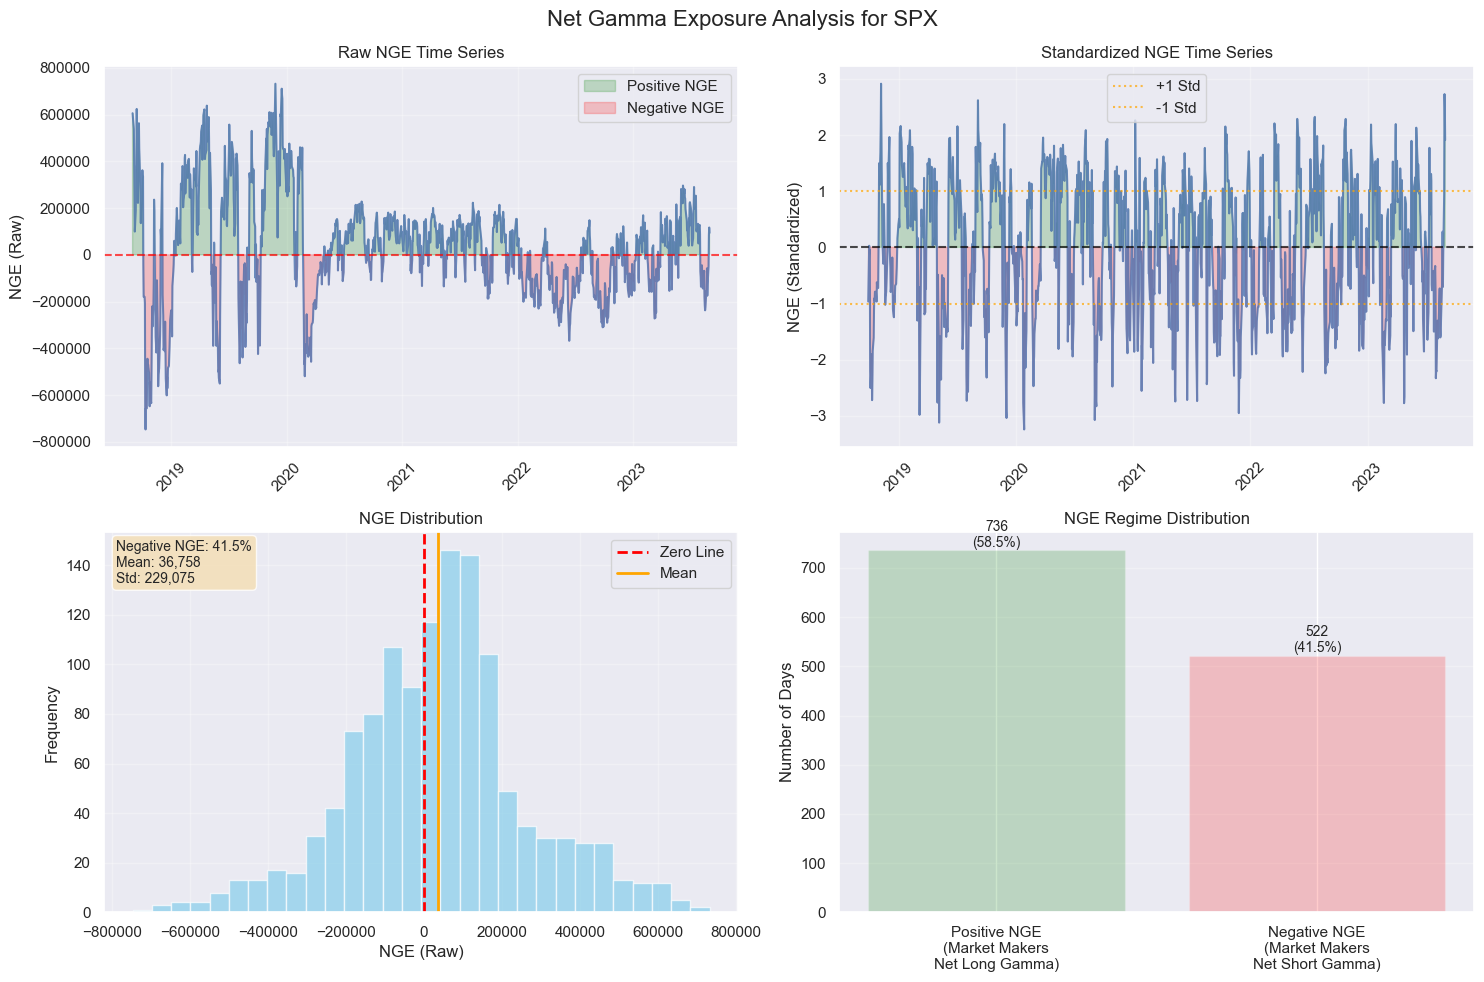


SPX NGE Summary Statistics:
----------------------------------------
Total observations: 1258
Positive NGE days: 736 (58.5%)
Negative NGE days: 522 (41.5%)
Mean NGE: 36,758
Median NGE: 45,968
Standard deviation: 229,075
Min NGE: -746,490
Max NGE: 731,803


In [6]:
visualize_single_ticker_nge(nge_daily, 'SPX')

In [7]:
nge_daily

ticker,date,nge_raw,num_contracts,nge_rolling_mean,nge_rolling_std,nge_standardized
str,date,f64,u32,f64,f64,f64
"""SPX""",2018-08-31,605588.1614,7042,null,null,null
"""SPX""",2018-09-04,537996.8253,6911,null,null,null
"""SPX""",2018-09-05,417433.2,7015,null,null,null
"""SPX""",2018-09-06,271759.2636,7334,null,null,null
"""SPX""",2018-09-07,99583.3045,7276,null,null,null
…,…,…,…,…,…,…
"""SPX""",2023-08-25,-124690.056,12857,-111776.891795,92916.794553,-0.138976
"""SPX""",2023-08-28,-48580.2544,12895,-120599.541425,75756.594426,0.950667
"""SPX""",2023-08-29,84297.0141,12449,-120803.852485,75166.528462,2.72862


# Price data preprocessing

In [8]:
price_data = pl.read_parquet('cleaned_data/SPY_combined_minute_data.parquet')

In [26]:
price_data

timestamp,open,high,low,close,date,year,month,day,hour,minute
"datetime[ns, UTC]",f32,f32,f32,f32,date,i32,i32,i32,i32,i32
2018-08-31 13:30:00 UTC,289.869995,289.88501,289.790009,289.850006,2018-08-31,2018,8,31,13,30
2018-08-31 13:31:00 UTC,289.834991,289.970001,289.820007,289.950012,2018-08-31,2018,8,31,13,31
2018-08-31 13:32:00 UTC,289.940002,290.040009,289.920013,290.040009,2018-08-31,2018,8,31,13,32
2018-08-31 13:33:00 UTC,290.029999,290.054993,289.950012,289.98999,2018-08-31,2018,8,31,13,33
2018-08-31 13:34:00 UTC,289.964996,290.035004,289.950012,289.975006,2018-08-31,2018,8,31,13,34
…,…,…,…,…,…,…,…,…,…,…
2023-08-31 19:55:00 UTC,450.915009,450.924988,450.600006,450.834991,2023-08-31,2023,8,31,19,55
2023-08-31 19:56:00 UTC,450.820007,450.820007,450.649994,450.709991,2023-08-31,2023,8,31,19,56
2023-08-31 19:57:00 UTC,450.709991,450.744995,450.595001,450.670013,2023-08-31,2023,8,31,19,57


In [23]:
def process_price_data(price_data):
    """
    Process SPY minute data to calculate returns for different time periods
    - Convert timezone from UTC to Eastern Time
    - Calculate r_ROD (overnight + first 30min + middle + second-to-last 30min)
    - Calculate r_LH (last 30min)
    """
    
    # Convert to pandas and handle timezone
    price_data = price_data.to_pandas()
    price_data['timestamp'] = price_data['timestamp'].dt.tz_convert('US/Eastern')
    price_data["date"] = price_data["timestamp"].dt.date
    price_data["hour"] = price_data["timestamp"].dt.hour
    price_data["minute"] = price_data["timestamp"].dt.minute
    
    # Extract key time points
    prev_close = price_data[(price_data["hour"] == 15) & (price_data["minute"] == 59)][["date", "close"]].rename(columns={"close": "prev_close"})
    prev_close['prev_close'] = prev_close['prev_close'].shift(1)
    prev_close = prev_close.dropna(subset=["prev_close"])
    
    close_1430 = price_data[(price_data["hour"] == 14) & (price_data["minute"] == 30)][["date", "close"]].rename(columns={"close": "close_1430"})
    close_1530 = price_data[(price_data["hour"] == 15) & (price_data["minute"] == 30)][["date", "close"]].rename(columns={"close": "close_1530"})  
    close_1559 = price_data[(price_data["hour"] == 15) & (price_data["minute"] == 59)][["date", "close"]].rename(columns={"close": "close_1559"})
    
    # Merge all dataframes
    result = prev_close.merge(close_1430, on='date', how='inner')
    result = result.merge(close_1530, on='date', how='inner')
    result = result.merge(close_1559, on='date', how='inner')
    
    # Calculate returns
    result['r_ROD'] = (result['close_1530'] / result['prev_close']) - 1
    result['r_LH'] = (result['close_1559'] / result['close_1530']) - 1
    
    return result

In [24]:
price_returns = process_price_data(price_data)

In [27]:
price_returns

,date,prev_close,close_1430,close_1530,close_1559,r_ROD,r_LH
0,2018-09-04,290.220001,289.720001,289.725006,289.855011,-0.001706,0.000449
1,2018-09-05,289.855011,289.059998,289.059998,289.049988,-0.002743,-0.000035
2,2018-09-06,289.049988,287.894989,288.484985,288.179993,-0.001955,-0.001057
3,2018-09-07,288.179993,287.795013,287.815002,287.700012,-0.001267,-0.000400
4,2018-09-10,287.700012,288.345001,288.260010,288.100006,0.001946,-0.000555
...,...,...,...,...,...,...,...
1291,2023-08-25,436.894989,440.325012,440.894989,440.059998,0.009156,-0.001894
1292,2023-08-28,440.059998,441.299988,441.674988,442.700012,0.003670,0.002321
1293,2023-08-29,442.700012,448.380005,449.170013,449.165009,0.014615,-0.000011
1294,2023-08-30,449.165009,450.220001,450.980011,451.010010,0.004041,0.000067


In [36]:
def merge_data_with_nge(price_returns, nge_daily):
    """
    Merge price return data with NGE data
    """
    
    # Convert nge_daily to pandas
    nge_df = nge_daily.to_pandas()
    nge_df['date'] = pd.to_datetime(nge_df['date']).dt.date
    
    # Merge on date
    merged = price_returns.merge(nge_df[['date', 'nge_raw']], on='date', how='inner')
    merged = merged.rename(columns={'nge_raw': 'NGE'})
    
    # Sort by date
    merged = merged.sort_values('date').reset_index(drop=True)
    
    # Create lagged NGE for conditioning (t-1 NGE)
    merged['NGE_lag1'] = merged['NGE'].shift(1)
    
    # Remove rows with missing values
    merged = merged.dropna().reset_index(drop=True)
    
    return merged

In [37]:
data = merge_data_with_nge(price_returns, nge_daily)
data

,date,prev_close,close_1430,close_1530,close_1559,r_ROD,r_LH,NGE,NGE_lag1
0,2018-09-05,289.855011,289.059998,289.059998,289.049988,-0.002743,-0.000035,417433.2000,537996.8253
1,2018-09-06,289.049988,287.894989,288.484985,288.179993,-0.001955,-0.001057,271759.2636,417433.2000
2,2018-09-07,288.179993,287.795013,287.815002,287.700012,-0.001267,-0.000400,99583.3045,271759.2636
3,2018-09-10,287.700012,288.345001,288.260010,288.100006,0.001946,-0.000555,191393.7489,99583.3045
4,2018-09-11,288.100006,289.359985,289.190002,289.114990,0.003783,-0.000259,358540.3597,191393.7489
...,...,...,...,...,...,...,...,...,...
1250,2023-08-25,436.894989,440.325012,440.894989,440.059998,0.009156,-0.001894,-124690.0560,-174493.9638
1251,2023-08-28,440.059998,441.299988,441.674988,442.700012,0.003670,0.002321,-48580.2544,-124690.0560
1252,2023-08-29,442.700012,448.380005,449.170013,449.165009,0.014615,-0.000011,84297.0141,-48580.2544
1253,2023-08-30,449.165009,450.220001,450.980011,451.010010,0.004041,0.000067,116898.1565,84297.0141


# Conditional Regression & Interaction Regression

In [45]:
def conditional_regression(data):
    """
    Perform conditional regression based on NGE sign
    """
    
    # Split data based on lagged NGE sign
    positive_nge = data[data['NGE_lag1'] >= 0].copy()
    negative_nge = data[data['NGE_lag1'] < 0].copy()
    
    results = {}
    
    # Regression for positive NGE
    if len(positive_nge) > 10:
        X_pos = sm.add_constant(positive_nge['r_ROD'])
        y_pos = positive_nge['r_LH']
        model_pos = sm.OLS(y_pos, X_pos).fit(cov_type='HAC', cov_kwds={'maxlags': 5})
        
        print("\nRegression Results for NGE_t-1 >= 0:")
        print(model_pos.summary())
        
        results['positive'] = {
            'model': model_pos,
            'n_obs': len(positive_nge),
            'intercept': model_pos.params['const'],
            'beta_ROD': model_pos.params['r_ROD'],
            'r_squared': model_pos.rsquared,
            'intercept_pval': model_pos.pvalues['const'],
            'beta_pval': model_pos.pvalues['r_ROD']
        }
    
    # Regression for negative NGE  
    if len(negative_nge) > 10:
        X_neg = sm.add_constant(negative_nge['r_ROD'])
        y_neg = negative_nge['r_LH']
        model_neg = sm.OLS(y_neg, X_neg).fit(cov_type='HAC', cov_kwds={'maxlags': 5})
        
        print("\nRegression Results for NGE_t-1 < 0:")
        print(model_neg.summary())
        
        results['negative'] = {
            'model': model_neg,
            'n_obs': len(negative_nge),
            'intercept': model_neg.params['const'],
            'beta_ROD': model_neg.params['r_ROD'],
            'r_squared': model_neg.rsquared,
            'intercept_pval': model_neg.pvalues['const'],
            'beta_pval': model_neg.pvalues['r_ROD']
        }
    
    # Create summary table
    print("\n" + "="*80)
    print("SUMMARY TABLE")
    print("="*80)
    print(f"{'Condition':<15} {'Intercept':<12} {'β_ROD':<12} {'R² (%)':<8} {'N':<8}")
    print("-" * 80)
    
    if 'positive' in results:
        r = results['positive']
        sig_intercept = "***" if r['intercept_pval'] < 0.01 else "**" if r['intercept_pval'] < 0.05 else "*" if r['intercept_pval'] < 0.1 else ""
        sig_beta = "***" if r['beta_pval'] < 0.01 else "**" if r['beta_pval'] < 0.05 else "*" if r['beta_pval'] < 0.1 else ""
        print(f"{'NGE_t-1 >= 0':<15} {r['intercept']:<8.3f}{sig_intercept:<4} {r['beta_ROD']:<8.3f}{sig_beta:<4} {r['r_squared']*100:<8.2f} {r['n_obs']:<8}")
    
    if 'negative' in results:
        r = results['negative']
        sig_intercept = "***" if r['intercept_pval'] < 0.01 else "**" if r['intercept_pval'] < 0.05 else "*" if r['intercept_pval'] < 0.1 else ""
        sig_beta = "***" if r['beta_pval'] < 0.01 else "**" if r['beta_pval'] < 0.05 else "*" if r['beta_pval'] < 0.1 else ""
        print(f"{'NGE_t-1 < 0':<15} {r['intercept']:<8.3f}{sig_intercept:<4} {r['beta_ROD']:<8.3f}{sig_beta:<4} {r['r_squared']*100:<8.2f} {r['n_obs']:<8}")
    
    print("Significance levels: *** 1%, ** 5%, * 10%")
    
    return results

def interaction_regression(data):
    """
    Perform interaction term regression
    """
    
    # Standardize NGE for better interpretation
    data['NGE_lag1_std'] = (data['NGE_lag1'] - data['NGE_lag1'].mean()) / data['NGE_lag1'].std()
    
    # Create interaction terms
    data['NGE_negative_indicator'] = (data['NGE_lag1'] < 0).astype(int)
    data['interaction_indicator'] = data['NGE_negative_indicator'] * data['r_ROD']
    data['interaction_continuous'] = data['NGE_lag1_std'] * data['r_ROD']
    
    models = {}
    
    # Model 1: Basic momentum regression
    X1 = sm.add_constant(data['r_ROD'])
    y = data['r_LH']
    model1 = sm.OLS(y, X1).fit(cov_type='HAC', cov_kwds={'maxlags': 5})
    models['model1'] = model1
    
    print("\nModel 1: Basic Momentum Regression")
    print("r_LH = α + β₁*r_ROD + ε")
    print(model1.summary())
    
    # Model 2: Indicator interaction
    X2 = sm.add_constant(data[['r_ROD', 'interaction_indicator']])
    model2 = sm.OLS(y, X2).fit(cov_type='HAC', cov_kwds={'maxlags': 5})
    models['model2'] = model2
    
    print("\nModel 2: Indicator Interaction")
    print("r_LH = α + β₁*r_ROD + β₂*I_NGE<0*r_ROD + ε")
    print(model2.summary())
    
    # Model 3: Continuous interaction (main model)
    X3 = sm.add_constant(data[['r_ROD', 'interaction_continuous', 'NGE_lag1_std']])
    model3 = sm.OLS(y, X3).fit(cov_type='HAC', cov_kwds={'maxlags': 5})
    models['model3'] = model3
    
    print("\nModel 3: Continuous Interaction (Main Model)")
    print("r_LH = α + β₁*r_ROD + β₂*NGE*r_ROD + β₃*NGE + ε")
    print(model3.summary())
    
    # Create summary table
    print("\n" + "="*100)
    print("REGRESSION SUMMARY TABLE")
    print("="*100)
    
    print(f"{'Variable':<20} {'Model 1':<15} {'Model 2':<15} {'Model 3':<15}")
    print("-" * 100)
    
    # Helper function to format coefficients
    def format_coef(model, var_name):
        if var_name in model.params.index:
            coef = model.params[var_name]
            pval = model.pvalues[var_name]
            sig = "***" if pval < 0.01 else "**" if pval < 0.05 else "*" if pval < 0.1 else ""
            return f"{coef:>8.3f}{sig:<3}"
        return "---"
    
    print(f"{'Intercept':<20} {format_coef(model1, 'const'):<15} {format_coef(model2, 'const'):<15} {format_coef(model3, 'const'):<15}")
    print(f"{'r_ROD':<20} {format_coef(model1, 'r_ROD'):<15} {format_coef(model2, 'r_ROD'):<15} {format_coef(model3, 'r_ROD'):<15}")
    print(f"{'I_NGE<0 * r_ROD':<20} {'---':<15} {format_coef(model2, 'interaction_indicator'):<15} {'---':<15}")
    print(f"{'NGE * r_ROD':<20} {'---':<15} {'---':<15} {format_coef(model3, 'interaction_continuous'):<15}")
    print(f"{'NGE':<20} {'---':<15} {'---':<15} {format_coef(model3, 'NGE_lag1_std'):<15}")
    
    print(f"\n{'R² (%)':<20} {model1.rsquared*100:<15.2f} {model2.rsquared*100:<15.2f} {model3.rsquared*100:<15.2f}")
    print(f"{'N':<20} {model1.nobs:<15.0f} {model2.nobs:<15.0f} {model3.nobs:<15.0f}")
    print("\nSignificance levels: *** 1%, ** 5%, * 10%")
    
    return models

In [46]:
conditional_results = conditional_regression(data)


Regression Results for NGE_t-1 >= 0:
                            OLS Regression Results                            
Dep. Variable:                   r_LH   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                   0.05657
Date:                Wed, 06 Aug 2025   Prob (F-statistic):              0.812
Time:                        20:59:31   Log-Likelihood:                 3447.9
No. Observations:                 733   AIC:                            -6892.
Df Residuals:                     731   BIC:                            -6883.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -9.

In [94]:
interaction_results = interaction_regression(data)


Model 1: Basic Momentum Regression
r_LH = α + β₁*r_ROD + ε
                            OLS Regression Results                            
Dep. Variable:                   r_LH   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                    0.9981
Date:                Wed, 06 Aug 2025   Prob (F-statistic):              0.318
Time:                        21:38:26   Log-Likelihood:                 5183.9
No. Observations:                1255   AIC:                        -1.036e+04
Df Residuals:                    1253   BIC:                        -1.035e+04
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------

# Trading Strategy & Backtesting

In [90]:
def implement_trading_strategy(data):
    """
    Implement trading strategy based on conditional regression results
    Strategy: When NGE_t-1 < 0, trade in direction of r_ROD on day t to predict r_LH
    """
    
    # Create trading signals
    data_strategy = data.copy()
    
    # Signal generation logic:
    # When NGE_t-1 < 0 (market makers net short gamma):
    # - If r_ROD > 0 (market moves up during ROD), expect positive r_LH -> Long
    # - If r_ROD < 0 (market moves down during ROD), expect positive momentum continuation -> Short
    
    data_strategy['signal'] = 0  # 0 = no position, 1 = long, -1 = short
    
    # Only trade when NGE_t-1 < 0 (negative gamma environment)
    negative_nge_mask = data_strategy['NGE_lag1'] < 0
    
    # Long when r_ROD > 0, Short when r_ROD < 0
    data_strategy.loc[negative_nge_mask & (data_strategy['r_ROD'] > 0), 'signal'] = 1
    data_strategy.loc[negative_nge_mask & (data_strategy['r_ROD'] < 0), 'signal'] = -1
    
    # Calculate strategy returns
    data_strategy['strategy_return'] = data_strategy['signal'] * data_strategy['r_LH']
    
    # Calculate cumulative returns
    data_strategy['cumulative_return'] = (1 + data_strategy['strategy_return']).cumprod() - 1
    data_strategy['cumulative_buy_hold'] = (1 + data_strategy['r_LH']).cumprod() - 1
    
    # Performance metrics
    total_trades = (data_strategy['signal'] != 0).sum()
    long_trades = (data_strategy['signal'] == 1).sum()
    short_trades = (data_strategy['signal'] == -1).sum()
    
    strategy_returns = data_strategy['strategy_return'][data_strategy['signal'] != 0]
    win_rate = (strategy_returns > 0).mean() if len(strategy_returns) > 0 else 0
    
    avg_return_per_trade = strategy_returns.mean() if len(strategy_returns) > 0 else 0
    std_return_per_trade = strategy_returns.std() if len(strategy_returns) > 0 else 0
    
    total_return = data_strategy['cumulative_return'].iloc[-1]
    buy_hold_return = data_strategy['cumulative_buy_hold'].iloc[-1]
    
    # Sharpe ratio (annualized, assuming ~250 trading days)
    if std_return_per_trade > 0:
        sharpe_ratio = (avg_return_per_trade / std_return_per_trade) * np.sqrt(250)
    else:
        sharpe_ratio = 0
    
    print(f"Strategy Performance Summary:")
    print(f"Total Trades: {total_trades}")
    print(f"Long Trades: {long_trades}")  
    print(f"Short Trades: {short_trades}")
    print(f"Win Rate: {win_rate:.2%}")
    print(f"Average Return per Trade: {avg_return_per_trade:.4f} ({avg_return_per_trade*100:.2f}%)")
    print(f"Std Return per Trade: {std_return_per_trade:.4f}")
    print(f"Total Strategy Return: {total_return:.2%}")
    print(f"Buy & Hold Return: {buy_hold_return:.2%}")
    print(f"Excess Return: {(total_return - buy_hold_return):.2%}")
    print(f"Annualized Sharpe Ratio: {sharpe_ratio:.3f}")
    
    return data_strategy

def create_visualizations(data_strategy):
    """
    Create visualizations for the analysis
    """
    
    fig, axes = plt.subplots(1, 1, figsize=(15,6))
    
    # Plot 1: Cumulative Returns
    axes.plot(data_strategy['date'], data_strategy['cumulative_return'] * 100, 
                   label='Gamma Strategy', linewidth=2)
    axes.plot(data_strategy['date'], data_strategy['cumulative_buy_hold'] * 100, 
                   label='Buy & Hold', linewidth=2)
    axes.set_title('Cumulative Returns: Gamma Strategy vs Buy & Hold', fontsize=14)
    axes.set_ylabel('Cumulative Return (%)')
    axes.legend()
    axes.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [91]:
strategy_data = implement_trading_strategy(data)

Strategy Performance Summary:
Total Trades: 522
Long Trades: 271
Short Trades: 251
Win Rate: 52.11%
Average Return per Trade: 0.0004 (0.04%)
Std Return per Trade: 0.0054
Total Strategy Return: 21.40%
Buy & Hold Return: -4.00%
Excess Return: 25.40%
Annualized Sharpe Ratio: 1.121


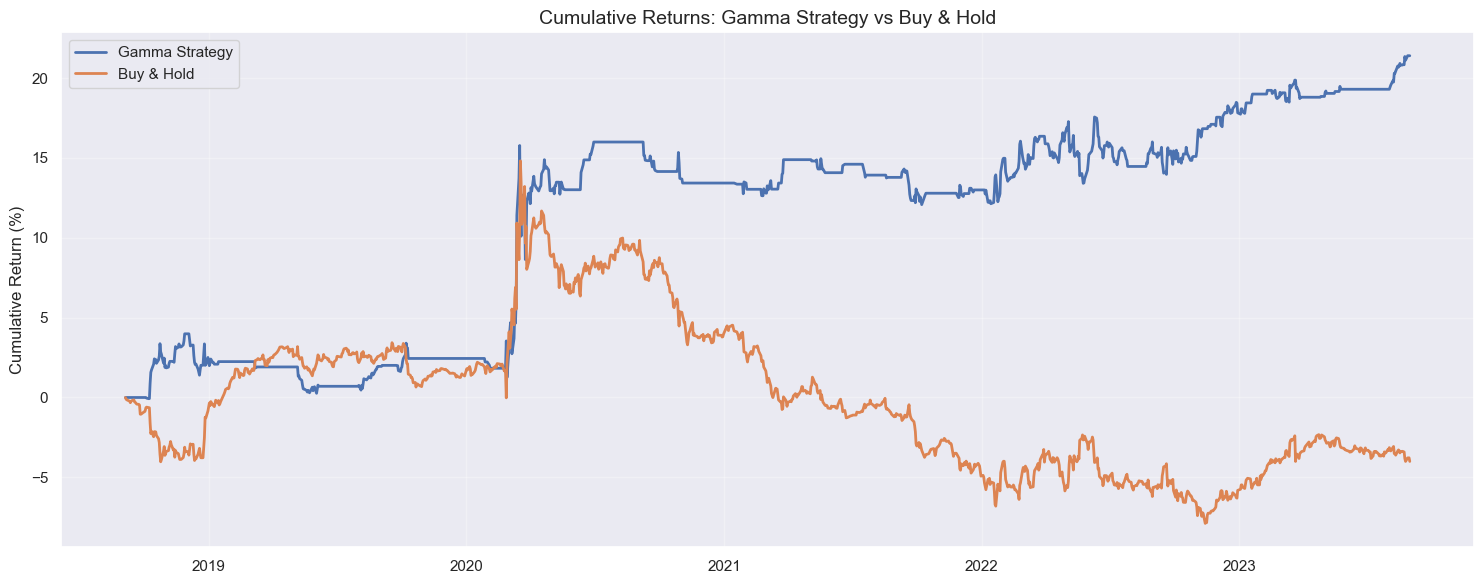

In [92]:
create_visualizations(strategy_data)

In [88]:
def implement_trading_strategy(data):
    """
    Implement multiple trading strategies:
    1. Gamma Strategy: When NGE_t-1 < 0, trade in direction of r_ROD
    2. Momentum Strategy: Always trade in direction of r_ROD (baseline)
    3. Buy & Hold: Hold r_LH returns
    """
    
    data_strategy = data.copy()
    
    # Strategy 1: Gamma-based strategy
    data_strategy['gamma_signal'] = 0
    negative_nge_mask = data_strategy['NGE_lag1'] < 0
    data_strategy.loc[negative_nge_mask & (data_strategy['r_ROD'] > 0), 'gamma_signal'] = 1
    data_strategy.loc[negative_nge_mask & (data_strategy['r_ROD'] < 0), 'gamma_signal'] = -1
    
    # Strategy 2: Pure momentum strategy (intraday momentum baseline)
    data_strategy['momentum_signal'] = 0
    data_strategy.loc[data_strategy['r_ROD'] > 0, 'momentum_signal'] = 1
    data_strategy.loc[data_strategy['r_ROD'] < 0, 'momentum_signal'] = -1
    
    # Calculate returns for each strategy
    data_strategy['gamma_return'] = data_strategy['gamma_signal'] * data_strategy['r_LH']
    data_strategy['momentum_return'] = data_strategy['momentum_signal'] * data_strategy['r_LH']
    data_strategy['buy_hold_return'] = data_strategy['r_LH']
    
    # Calculate cumulative returns
    data_strategy['cum_gamma'] = (1 + data_strategy['gamma_return']).cumprod() - 1
    data_strategy['cum_momentum'] = (1 + data_strategy['momentum_return']).cumprod() - 1
    data_strategy['cum_buy_hold'] = (1 + data_strategy['buy_hold_return']).cumprod() - 1
    
    # Performance analysis
    strategies = {
        'Gamma Strategy': {
            'returns': data_strategy['gamma_return'][data_strategy['gamma_signal'] != 0],
            'total_return': data_strategy['cum_gamma'].iloc[-1],
            'total_trades': (data_strategy['gamma_signal'] != 0).sum(),
            'long_trades': (data_strategy['gamma_signal'] == 1).sum(),
            'short_trades': (data_strategy['gamma_signal'] == -1).sum()
        },
        'Momentum Strategy': {
            'returns': data_strategy['momentum_return'][data_strategy['momentum_signal'] != 0],
            'total_return': data_strategy['cum_momentum'].iloc[-1],
            'total_trades': (data_strategy['momentum_signal'] != 0).sum(),
            'long_trades': (data_strategy['momentum_signal'] == 1).sum(),
            'short_trades': (data_strategy['momentum_signal'] == -1).sum()
        },
        'Buy & Hold': {
            'returns': data_strategy['buy_hold_return'],
            'total_return': data_strategy['cum_buy_hold'].iloc[-1],
            'total_trades': len(data_strategy),
            'long_trades': len(data_strategy),
            'short_trades': 0
        }
    }
    
    print("=" * 60)
    print("STRATEGY PERFORMANCE COMPARISON")
    print("=" * 60)
    
    for strategy_name, metrics in strategies.items():
        returns = metrics['returns']
        
        if len(returns) > 0:
            win_rate = (returns > 0).mean()
            avg_return = returns.mean()
            std_return = returns.std()
            sharpe_ratio = (avg_return / std_return) * np.sqrt(250) if std_return > 0 else 0
        else:
            win_rate = avg_return = std_return = sharpe_ratio = 0
        
        print(f"\n{strategy_name}:")
        print(f"  Total Return: {metrics['total_return']:.2%}")
        print(f"  Total Trades: {metrics['total_trades']}")
        print(f"  Long/Short: {metrics['long_trades']}/{metrics['short_trades']}")
        print(f"  Win Rate: {win_rate:.2%}")
        print(f"  Avg Return/Trade: {avg_return:.4f} ({avg_return*100:.2f}%)")
        print(f"  Sharpe Ratio: {sharpe_ratio:.3f}")
    
    return data_strategy

def create_visualizations(data_strategy):
    """
    Create visualizations comparing all three strategies
    """
    
    fig, axes = plt.subplots(1, 1, figsize=(15, 6))

    axes.plot(data_strategy['date'], data_strategy['cum_gamma'] * 100, 
                 label='Gamma Strategy', linewidth=2)
    axes.plot(data_strategy['date'], data_strategy['cum_momentum'] * 100, 
                 label='Momentum Strategy', linewidth=2)
    axes.plot(data_strategy['date'], data_strategy['cum_buy_hold'] * 100, 
                 label='Buy & Hold', linewidth=2)
    axes.set_title('Cumulative Returns: Strategy Comparison', fontsize=14)
    axes.set_ylabel('Cumulative Return (%)')
    axes.legend()
    axes.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [80]:
strategy_data = implement_trading_strategy(data)

STRATEGY PERFORMANCE COMPARISON

Gamma Strategy:
  Total Return: 21.40%
  Total Trades: 522
  Long/Short: 271/251
  Win Rate: 52.11%
  Avg Return/Trade: 0.0004 (0.04%)
  Sharpe Ratio: 1.121

Momentum Strategy:
  Total Return: 38.57%
  Total Trades: 1255
  Long/Short: 682/573
  Win Rate: 53.07%
  Avg Return/Trade: 0.0003 (0.03%)
  Sharpe Ratio: 1.087

Buy & Hold:
  Total Return: -4.00%
  Total Trades: 1255
  Long/Short: 1255/0
  Win Rate: 47.97%
  Avg Return/Trade: -0.0000 (-0.00%)
  Sharpe Ratio: -0.101


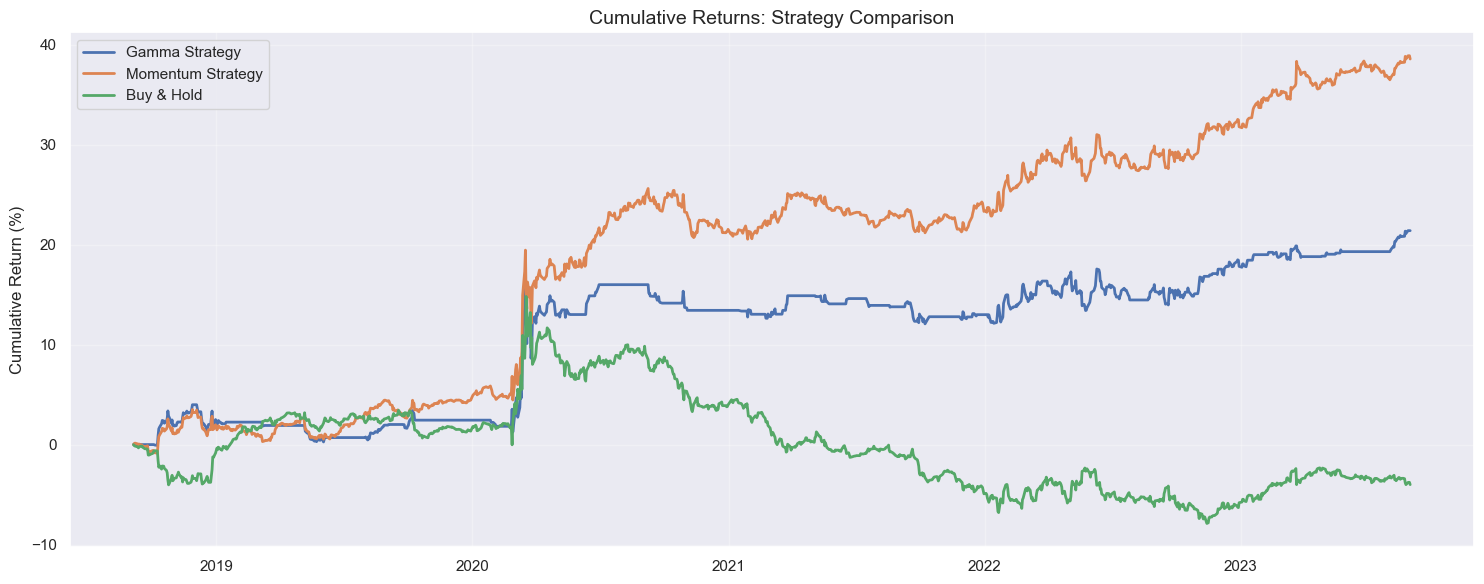

In [89]:
create_visualizations(strategy_data)